**Author**: JW Debelius (justine.debelius@ki.se)<br>
**Date**: September 2021<br>
**Enviroment**: `qiime2-2021.8-dev`<br>
**Python version**: 3.8<br>
**Extra packages**: None<br>
**QIIME version**: 2021.8-dev<br>
**Extra Plugins**: q2-sidle (memory refactor); RESCRIPt (v. )

# Vaginal Data Preperation

## Background

## Data Download and avaliability

## Processing Approach

### Set up

In [2]:
import os
import shutil

import numpy as np
import pandas as pd

from qiime2 import Metadata, Artifact

In [3]:
input_dir = 'data/inputs/vaginal/sequences/'
output_dir = 'data/output/real_optivag/'

In [4]:
all_input_samples = os.listdir(input_dir)
# all_input_samples

In [5]:
def get_sample_descriptor(fp):
    name = fp.split('.')[0]
    abs_fp = os.path.abspath(fp)
    position, study_info, sample_info = name.split("__")
    [pool_id, rep, region, pcr, dir_] = sample_info.split('_')

    dir_label = {'R1': 'forward', 'R2': 'reverse'}[dir_]

    summary = pd.Series(
        data={'{}-absolute-filepath'.format(dir_label): abs_fp,
              'sample-id': '{}_{}'.format(pool_id, rep),
              'pool': pool_id,
              'replicate': rep,
              'region': region,
              'pcr_type': pcr},
        name='_'.join(sample_info.split('_')[:-1]))
    return summary

# Regional Preperation

## V1-3

In [6]:
os.makedirs(f'{output_dir}/1.regional-preperation/v1-3/', exist_ok=True)

v13_manifest_fp = f'{output_dir}1.regional-preperation/v1-3/manifest.tsv'
v13_demux_fp = f'{output_dir}1.regional-preperation/v1-3/demux-seqs.qza'
v13_primer_fp = f'{output_dir}1.regional-preperation/v1-3/trimmed-seqs.qza'
v13_table_fp = f'{output_dir}/1.regional-preperation/v1-3/asv-table.qza'
v13_repseq_fp = f'{output_dir}/1.regional-preperation/v1-3/representative-sequences.qza'
v13_stats_fp = f'{output_dir}/1.regional-preperation/v1-3/denoising-statitics.qza'

### Importing into QIIME 2

In [7]:
v13_sample_files_fwd = [
    fp for fp in all_input_samples if ('V1V3Old_2step_R1' in fp)
]
v13_sample_files_rev = [
    fp for fp in all_input_samples if ('V1V3Old_2step_R2' in fp)
]
v13_samples = pd.concat(axis=1, objs=[
    get_sample_descriptor(f'{input_dir}/{fp}') for fp in v13_sample_files_fwd
]).T
v13_samples.rename(columns={'forward-absolute-filepath': 'absolute-filepath'},
                   inplace=True
                   )
v13_samples.set_index("sample-id", inplace=True)
v13_samples = Metadata(v13_samples)
v13_samples.save(v13_manifest_fp)

'data/output/real_optivag/1.regional-preperation/v1-3/manifest.tsv'

In [8]:
!qiime tools import \
 --type 'SampleData[SequencesWithQuality]' \
 --input-format SingleEndFastqManifestPhred33V2 \
 --input-path $v13_manifest_fp \
 --output-path $v13_demux_fp

Imported data/output/real_optivag/1.regional-preperation/v1-3/manifest.tsv as SingleEndFastqManifestPhred33V2 to data/output/real_optivag/1.regional-preperation/v1-3/demux-seqs.qza


### Primer trimming

The reads were already demultiplexed by region, and so the primer trimming is more of a formality since they were, for the most part, trimmed before the reads were deposited

In [9]:
!qiime cutadapt trim-single \
 --i-demultiplexed-sequences $v13_demux_fp \
 --p-front 'AGAGTTTGATCCTGGCTCAG' \
 --p-no-discard-untrimmed \
 --o-trimmed-sequences $v13_primer_fp

Saved SampleData[SequencesWithQuality] to: data/output/real_optivag/1.regional-preperation/v1-3/trimmed-seqs.qza


### Denoising

In [10]:
!qiime dada2 denoise-single \
 --i-demultiplexed-seqs $v13_primer_fp \
 --p-trunc-len 280 \
 --p-n-threads 4 \
 --o-table $v13_table_fp \
 --o-representative-sequences $v13_repseq_fp \
 --o-denoising-stats $v13_stats_fp 

Saved FeatureTable[Frequency] to: data/output/real_optivag//1.regional-preperation/v1-3/asv-table.qza
Saved FeatureData[Sequence] to: data/output/real_optivag//1.regional-preperation/v1-3/representative-sequences.qza
Saved SampleData[DADA2Stats] to: data/output/real_optivag//1.regional-preperation/v1-3/denoising-statitics.qza


## V34

In [11]:
os.makedirs(f'{output_dir}/1.regional-preperation/v3-4/', exist_ok=True)
v34_manifest_fp = f'{output_dir}/1.regional-preperation/v3-4/manifest.tsv'
v34_demux_fp = f'{output_dir}/1.regional-preperation/v3-4/demux-seqs.qza'
v34_trimmed_fp = f'{output_dir}/1.regional-preperation/v3-4/trimmed-seqs.qza'
v34_table_fp = f'{output_dir}/1.regional-preperation/v3-4/asv-table.qza'
v34_rep_seqs_fp = f'{output_dir}/1.regional-preperation/v3-4/representative-sequences.qza'
v34_dada2_stats_fp = f'{output_dir}/1.regional-preperation/v3-4/denoising-statitics.qza'

### Import into QIIME 2

In [12]:
v34_sample_files_fwd = [
    fp for fp in all_input_samples if ('V3V4_2step_R1' in fp)
]
v34_sample_files_rev = [
    fp for fp in all_input_samples if ('V3V4_2step_R1' in fp)
]
v34_samples = pd.concat(axis=1, objs=[
    get_sample_descriptor(f'{input_dir}/{fp}') for fp in v34_sample_files_fwd
]).T
v34_samples['reverse-absolute-filepath'] = \
    v34_samples['forward-absolute-filepath'].apply(
        lambda x: x.replace("R1", "R2"))
v34_samples.set_index("sample-id", inplace=True)


v34_samples = Metadata(v34_samples)
v34_samples.save(v34_manifest_fp)

'data/output/real_optivag//1.regional-preperation/v3-4/manifest.tsv'

In [13]:
!qiime tools import \
 --type 'SampleData[PairedEndSequencesWithQuality]' \
 --input-format PairedEndFastqManifestPhred33V2 \
 --input-path $v34_manifest_fp \
 --output-path $v34_demux_fp

Imported data/output/real_optivag//1.regional-preperation/v3-4/manifest.tsv as PairedEndFastqManifestPhred33V2 to data/output/real_optivag//1.regional-preperation/v3-4/demux-seqs.qza


## Primer Trimming

The sequences were again, already trimmed before they were deposited and so this is a clean up of already trimmed/demultiplexed sequences rather than a true demux. If the primers were still int he sequences, then I'd use `--discard-untrimmed` to do the regional demux

In [14]:
!qiime cutadapt trim-paired \
 --i-demultiplexed-sequences $v34_demux_fp \
 --p-front-f CCTACGGGNGGCWGCAG \
 --p-front-r GACTACHVGGGTATCTAATCC \
 --p-no-discard-untrimmed \
 --o-trimmed-sequences $v34_trimmed_fp

Saved SampleData[PairedEndSequencesWithQuality] to: data/output/real_optivag//1.regional-preperation/v3-4/trimmed-seqs.qza


### DADA 2

In [15]:
!qiime dada2 denoise-paired \
 --i-demultiplexed-seqs $v34_trimmed_fp \
 --p-trunc-len-f 280 \
 --p-trunc-len-r 280 \
 --p-n-threads 4 \
 --o-table $v34_table_fp \
 --o-representative-sequences $v34_rep_seqs_fp \
 --o-denoising-stats $v34_dada2_stats_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag//1.regional-preperation/v3-4/asv-table.qza
Saved FeatureData[Sequence] to: data/output/real_optivag//1.regional-preperation/v3-4/representative-sequences.qza
Saved SampleData[DADA2Stats] to: data/output/real_optivag//1.regional-preperation/v3-4/denoising-statitics.qza


# Reference data

In [16]:
os.makedirs('data/reference/optivag/raw/', exist_ok=True)

raw_seq_address = ('https://github.com/ctmrbio/optivag/blob/master/database/'
                   'db/16S/v0.1/optivag_db.fasta.gz?raw=true')
optivag_meta_address = ('https://github.com/ctmrbio/optivag/raw/master/'
                        'database/db/16S/v0.1/optivag_seqinfo.csv')

optivag_seq_fp = 'data/reference/optivag/optivag_v01_seqs.qza'
optivag_tax_fp = 'data/reference/optivag/optivag_v01_taxonomy.qza'

!rm -r 'data/reference/optivag/optivag_v01_taxonomy.qza'

# # !ls 
if os.path.exists(optivag_seq_fp) == False:
    !wget $raw_seq_address
    shutil.move('optivag_db.fasta.gz?raw=true', 
                'data/reference/optivag/raw/optivag_v01_seqs.fasta.gz')
    !gunzip data/reference/optivag/raw/optivag_v01_seqs.fasta.gz    
    !qiime tools import \
     --type 'FeatureData[Sequence]' \
     --input-path data/reference/optivag/raw/optivag_v01_seqs.fasta \
     --output-path $optivag_seq_fp
    
if os.path.exists(optivag_tax_fp) == False:
    !wget $optivag_meta_address
    shutil.move('optivag_seqinfo.csv',
                'data/reference/optivag/raw/optivag_seqinfo.csv')
    optivag_taxa = pd.read_csv('data/reference/optivag/raw/optivag_seqinfo.csv',
                               sep=',',
                               dtype=str
                               )
    # QIIME is really picky about the column names for certain things
    optivag_taxa.rename(columns={"Seq_ID": 'Feature ID',
                                 'Full_taxonomy': 'Taxon',
                                 'Species': 'species',
                                 }, 
                        inplace=True)
    levels = ['k', 'p', 'c', 'o', 'f', 'g', 's']
    optivag_taxa['Taxon'] = optivag_taxa['Taxon'].apply(
        lambda x: ';'.join([f'{l}__{t}' for l, t in zip(*(levels, x.split(";")))])
    )
    optivag_taxa = optivag_taxa[['Feature ID', 'Taxon', 'species']].copy()
    optivag_taxa.set_index('Feature ID', inplace=True)
    
    # Converts the information to an Artifact and then saves it
    optivag_taxa = Artifact.import_data('FeatureData[Taxonomy]', optivag_taxa)
    optivag_taxa.save(optivag_tax_fp)
    
shutil.rmtree('data/reference/optivag/raw/')

--2022-01-03 13:28:43--  https://github.com/ctmrbio/optivag/raw/master/database/db/16S/v0.1/optivag_seqinfo.csv
Resolving github.com... 140.82.121.3
Connecting to github.com|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ctmrbio/optivag/master/database/db/16S/v0.1/optivag_seqinfo.csv [following]
--2022-01-03 13:28:45--  https://raw.githubusercontent.com/ctmrbio/optivag/master/database/db/16S/v0.1/optivag_seqinfo.csv
Resolving raw.githubusercontent.com... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234751 (229K) [text/plain]
Saving to: 'optivag_seqinfo.csv'

optivag_seqinfo.csv 100%[===================>] 229.25K  1.40MB/s    in 0.2s    

2022-01-03 13:28:46 (1.40 MB/s) - 'optivag_seqinfo.csv' saved [234751/234751]



Reviewing the taxa, I want to filter and discard anything that doesn't have an order annotation int he database.

In [17]:
!qiime taxa filter-seqs \
 --i-sequences $optivag_seq_fp \
 --i-taxonomy $optivag_tax_fp \
 --p-include 'o__,f__,g__,s__' \
 --o-filtered-sequences $optivag_seq_fp

Saved FeatureData[Sequence] to: data/reference/optivag/optivag_v01_seqs.qza


# Per-Region characterization

In [18]:
os.makedirs(f'{output_dir}/2.reconstruction/1.v13-only', exist_ok=True)
os.makedirs(f'{output_dir}/2.reconstruction/2.v34-only', exist_ok=True)

## v1-3 Only

In [19]:
v13_table_in = f'{output_dir}/1.regional-preperation/v1-3/asv-table.qza'
v13_repseq_in = f'{output_dir}/1.regional-preperation/v1-3/representative-sequences.qza'

v13_dir = f'{output_dir}2.reconstruction/1.v13-only'
os.makedirs(v13_dir, exist_ok=True)

v13_ref_reads_fp = f'{v13_dir}/optivag-v13-reads.qza'
v13_classifier_fp = f'{v13_dir}/optivag-v13-feature-classifier.qza'
v13_taxonomy_fp = f'{v13_dir}/taxonomy.qza'
v13_table_fp = f'{v13_dir}/table.qza'
v13_species_fp = f'{v13_dir}/species.qza'

### Regional taxonomic classification

In [20]:
!qiime feature-classifier extract-reads \
 --i-sequences $optivag_seq_fp \
 --p-f-primer AGAGTTTGATCCTGGCTCAG \
 --p-r-primer ATTACCGCGGCTGCTGG \
 --p-trunc-len 300 \
 --o-reads $v13_ref_reads_fp

!qiime feature-classifier fit-classifier-naive-bayes \
 --i-reference-reads $v13_ref_reads_fp \
 --i-reference-taxonomy $optivag_tax_fp \
 --o-classifier $v13_classifier_fp

Saved FeatureData[Sequence] to: data/output/real_optivag/2.reconstruction/1.v13-only/optivag-v13-reads.qza
Saved TaxonomicClassifier to: data/output/real_optivag/2.reconstruction/1.v13-only/optivag-v13-feature-classifier.qza


### Taxonomic classification and table filtering

I want to keep featres that are defined with at least class level or higher

In [21]:
!qiime feature-classifier classify-sklearn \
 --i-reads $v13_repseq_in \
 --i-classifier $v13_classifier_fp \
 --o-classification $v13_taxonomy_fp

!qiime taxa filter-table \
 --i-table $v13_table_in \
 --i-taxonomy $v13_taxonomy_fp \
 --p-include ';f__' \
 --o-filtered-table $v13_table_fp

Saved FeatureData[Taxonomy] to: data/output/real_optivag/2.reconstruction/1.v13-only/taxonomy.qza
Saved FeatureTable[Frequency] to: data/output/real_optivag/2.reconstruction/1.v13-only/table.qza


And then wwe collapsed to a species level table

In [22]:
!qiime taxa collapse \
 --i-table $v13_table_fp \
 --i-taxonomy $v13_taxonomy_fp \
 --p-level 7 \
 --o-collapsed-table $v13_species_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag/2.reconstruction/1.v13-only/species.qza


## V34

In [23]:
v34_table_in = f'{output_dir}/1.regional-preperation/v3-4/asv-table.qza'
v34_repseq_in = f'{output_dir}/1.regional-preperation/v3-4/representative-sequences.qza'

v34_dir = f'{output_dir}2.reconstruction/2.v34-only'
os.makedirs(v34_dir, exist_ok=True)

v34_ref_reads_fp = f'{v34_dir}/optivag-v34-reads.qza'
v34_classifier_fp = f'{v34_dir}/optivag-v34-feature-classifier.qza'
v34_taxonomy_fp = f'{v34_dir}/taxonomy.qza'
v34_table_fp = f'{v34_dir}/table.qza'
v34_species_fp = f'{v34_dir}/species.qza'

### Build Classifier

In [24]:
!qiime feature-classifier extract-reads \
 --i-sequences $optivag_seq_fp \
 --p-f-primer CCTACGGGNGGCWGCAG \
 --p-r-primer GACTACHVGGGTATCTAATCC \
 --p-trunc-len 450 \
 --o-reads $v34_ref_reads_fp

!qiime feature-classifier fit-classifier-naive-bayes \
 --i-reference-reads $v34_ref_reads_fp \
 --i-reference-taxonomy $optivag_tax_fp \
 --o-classifier $v34_classifier_fp

Saved FeatureData[Sequence] to: data/output/real_optivag/2.reconstruction/2.v34-only/optivag-v34-reads.qza
Saved TaxonomicClassifier to: data/output/real_optivag/2.reconstruction/2.v34-only/optivag-v34-feature-classifier.qza


### Taxonomic classification and table filtering

I want to keep featres that are defined with at least class level or higher

In [25]:
!qiime feature-classifier classify-sklearn \
 --i-reads $v34_repseq_in \
 --i-classifier $v34_classifier_fp \
 --o-classification $v34_taxonomy_fp

!qiime taxa filter-table \
 --i-table $v34_table_in \
 --i-taxonomy $v34_taxonomy_fp \
 --p-include ';f__' \
 --o-filtered-table $v34_table_fp

Saved FeatureData[Taxonomy] to: data/output/real_optivag/2.reconstruction/2.v34-only/taxonomy.qza
Saved FeatureTable[Frequency] to: data/output/real_optivag/2.reconstruction/2.v34-only/table.qza


In [26]:
!qiime taxa collapse \
 --i-table $v34_table_fp \
 --i-taxonomy $v34_taxonomy_fp \
 --p-level 7 \
 --o-collapsed-table $v34_species_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag/2.reconstruction/2.v34-only/species.qza


# Regional Reconstruction

## Merge Regional tables
To combine the regions for OTU clustering and the combined ASV table, I need to merge the data.

In [27]:
merge_dir = f'{output_dir}2.reconstruction'
os.makedirs(merge_dir, exist_ok=True)
merged_table_fp = f'{merge_dir}/merged-table.qza'
merged_seqs_fp = f'{merge_dir}/merged-seqs.qza'

In [28]:
!qiime feature-table merge \
 --i-tables $v13_table_in \
 --i-tables $v34_table_in \
 --p-overlap-method 'sum' \
 --o-merged-table $merged_table_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag/2.reconstruction/merged-table.qza


In [29]:
!qiime feature-table merge-seqs \
 --i-data $v13_repseq_in \
 --i-data $v34_repseq_in \
 --o-merged-data $merged_seqs_fp

Saved FeatureData[Sequence] to: data/output/real_optivag/2.reconstruction/merged-seqs.qza


## OTU clustering

... 

In [30]:
otu_dir = f'{output_dir}/2.reconstruction/3.otu-clustering/'
os.makedirs(otu_dir, exist_ok=True)

otu_table_fp = f'{otu_dir}/table.qza'
otu_cluster_seqs_fp = f'{otu_dir}/clustered-seqs.qza'
otu_discard_seqs_fp = f'{otu_dir}/unmatched-seqs.qza'
otu_taxonomy_fp = f'{otu_dir}/taxonomy.qza'
otu_species_fp = f'{otu_dir}/species.qza'

We'll start clustering the sequences

In [31]:
!qiime vsearch cluster-features-closed-reference \
 --i-sequences $merged_seqs_fp \
 --i-table $merged_table_fp \
 --i-reference-sequences $optivag_seq_fp \
 --p-perc-identity 0.99 \
 --o-clustered-table $otu_table_fp \
 --o-clustered-sequences $otu_cluster_seqs_fp \
 --o-unmatched-sequences $otu_discard_seqs_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/3.otu-clustering//table.qza
Saved FeatureData[Sequence] to: data/output/real_optivag//2.reconstruction/3.otu-clustering//clustered-seqs.qza
Saved FeatureData[Sequence] to: data/output/real_optivag//2.reconstruction/3.otu-clustering//unmatched-seqs.qza


And then we add in the taxonomy

In [32]:
!cp $optivag_tax_fp $otu_taxonomy_fp

In [33]:
!qiime taxa collapse \
 --i-table $otu_table_fp \
 --i-taxonomy $otu_taxonomy_fp \
 --p-level 7 \
 --o-collapsed-table $otu_species_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/3.otu-clustering//species.qza


## Summed ASVs

For this, we will train a full lenght naive baysian classifier and throw everything in the mix.

In [34]:
smash_dir = f'{output_dir}/2.reconstruction/4.merged-asvs-smash'
os.makedirs(smash_dir, exist_ok=True)

smash_classifier_fp = f'{smash_dir}/optivag-feature-classifier.qza'
smash_taxonomy_fp = f'{smash_dir}/taxonomy.qza'
smash_table_fp = f'{smash_dir}/table.qza'
smash_species_fp = f'{smash_dir}/species.qza'

In [35]:
!qiime feature-classifier fit-classifier-naive-bayes \
 --i-reference-reads $optivag_seq_fp \
 --i-reference-taxonomy $optivag_tax_fp \
 --o-classifier $smash_classifier_fp

Saved TaxonomicClassifier to: data/output/real_optivag//2.reconstruction/4.merged-asvs-smash/optivag-feature-classifier.qza


In [36]:
!qiime feature-classifier classify-sklearn \
 --i-reads $merged_seqs_fp \
 --i-classifier $smash_classifier_fp \
 --o-classification $smash_taxonomy_fp

!qiime taxa filter-table \
 --i-table $merged_table_fp \
 --i-taxonomy $smash_taxonomy_fp \
 --p-include ';f__' \
 --o-filtered-table $smash_table_fp

Saved FeatureData[Taxonomy] to: data/output/real_optivag//2.reconstruction/4.merged-asvs-smash/taxonomy.qza
Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/4.merged-asvs-smash/table.qza


In [37]:
!qiime taxa collapse \
 --i-table $smash_table_fp \
 --i-taxonomy $smash_taxonomy_fp \
 --p-level 7 \
 --o-collapsed-table $smash_species_fp

Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/4.merged-asvs-smash/species.qza


## Sidle

I'm going to start a dask client for Sidle, since it uses dask for parallel processing

In [ ]:
client_address = str(client.scheduler.address)

In [51]:
sidle_dir = f'{output_dir}/2.reconstruction/5.sidle'
os.makedirs(sidle_dir, exist_ok=True)

# Regional filepaths
v13_region_dir = f'{sidle_dir}/v13-prep'
v34_region_dir = f'{sidle_dir}/v34-prep'
os.makedirs(v13_region_dir, exist_ok=True)
os.makedirs(v34_region_dir, exist_ok=True)


### Prepare regional sequences

We'll use the regions we trimmed for the feature classifieres for the individual regions here

In [232]:
!qiime dev refresh-cache

!qiime sidle prepare-extracted-region \
 --i-sequences $v13_ref_reads_fp \
 --p-trim-length 275 \
 --p-region v13 \
 --p-fwd-primer 'AGAGTTTGATCCTGGCTCAG' \
 --p-rev-primer 'ATTACCGCGGCTGCTGG' \
 --p-client-address $client_address \
 --o-collapsed-kmers $v13_region_dir/collapsed-kmers.qza \
 --o-kmer-map $v13_region_dir/kmer-map.qza

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved FeatureData[Sequence] to: data/output/real_optivag//2.reconstruction/5.sidle/v13-prep/collapsed-kmers.qza
Saved FeatureData[KmerMap] to: data/output/real_optivag//2.reconstruction/5.sidle/v13-prep/kmer-map.qza


In [233]:
!qiime sidle prepare-extracted-region \
 --i-sequences $v34_ref_reads_fp \
 --p-region v34 \
 --p-trim-length 400 \
 --p-fwd-primer 'CCTACGGGNGGCWGCAG' \
 --p-rev-primer 'GACTACHVGGGTATCTAATCC' \
 --p-client-address $client_address \
 --o-collapsed-kmers $v34_region_dir/collapsed-kmers.qza \
 --o-kmer-map $v34_region_dir/kmer-map.qza

Saved FeatureData[Sequence] to: data/output/real_optivag//2.reconstruction/5.sidle/v34-prep/collapsed-kmers.qza
Saved FeatureData[KmerMap] to: data/output/real_optivag//2.reconstruction/5.sidle/v34-prep/kmer-map.qza


Before we can do alignment, we need ot trim the sequences.

In [234]:
!qiime sidle trim-dada2-posthoc \
 --i-table $v13_table_fp \
 --i-representative-sequences $v13_repseq_fp \
 --p-trim-length 275 \
 --p-hashed-feature-ids \
 --o-trimmed-table $v13_region_dir/table.qza \
  --o-trimmed-representative-sequences $v13_region_dir/rep-seqs.qza

Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/5.sidle/v13-prep/table.qza
Saved FeatureData[Sequence] to: data/output/real_optivag//2.reconstruction/5.sidle/v13-prep/rep-seqs.qza


In [235]:
!qiime sidle trim-dada2-posthoc \
 --i-table $v34_table_fp \
 --i-representative-sequences $v34_rep_seqs_fp \
 --p-trim-length 400 \
 --p-hashed-feature-ids \
 --o-trimmed-table $v34_region_dir/table.qza \
 --o-trimmed-representative-sequences $v34_region_dir/rep-seqs.qza

Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/5.sidle/v34-prep/table.qza
Saved FeatureData[Sequence] to: data/output/real_optivag//2.reconstruction/5.sidle/v34-prep/rep-seqs.qza


And then we'll do regional alignments.

In [236]:
!qiime sidle align-regional-kmers \
 --i-kmers $v13_region_dir/collapsed-kmers.qza \
 --i-rep-seq $v13_region_dir/rep-seqs.qza \
 --p-region 'v13' \
 --p-max-mismatch 3 \
 --p-client-address $client_address \
 --o-regional-alignment $v13_region_dir/regional_alignment.qza

Saved FeatureData[KmerAlignment] to: data/output/real_optivag//2.reconstruction/5.sidle/v13-prep/regional_alignment.qza


In [237]:
!qiime sidle align-regional-kmers \
 --i-kmers $v34_region_dir/collapsed-kmers.qza \
 --i-rep-seq $v34_region_dir/rep-seqs.qza \
 --p-region 'v34' \
 --p-max-mismatch 4 \
 --p-client-address $client_address \
 --o-regional-alignment $v34_region_dir/regional_alignment.qza

Saved FeatureData[KmerAlignment] to: data/output/real_optivag//2.reconstruction/5.sidle/v34-prep/regional_alignment.qza


For the sake of demonstration, I want to reconstruct the database, and then table and taxonomy seperately. So, we start by reconstructing the database.

In [238]:
!qiime sidle reconstruct-database \
 --p-region v13 \
 --i-regional-alignment $v13_region_dir/regional_alignment.qza \
 --i-kmer-map $v13_region_dir/kmer-map.qza \
 --p-region v34 \
 --i-regional-alignment $v34_region_dir/regional_alignment.qza \
 --i-kmer-map $v34_region_dir/kmer-map.qza \
 --p-client-address $client_address \
 --o-database-map $sidle_dir/database-map.qza \
 --o-database-summary $sidle_dir/database-summary.qza

Saved FeatureData[SidleReconstruction] to: data/output/real_optivag//2.reconstruction/5.sidle/database-map.qza
Saved FeatureData[ReconstructionSummary] to: data/output/real_optivag//2.reconstruction/5.sidle/database-summary.qza


In [239]:
!qiime metadata tabulate \
 --m-input-file $sidle_dir/database-summary.qza \
 --o-visualization $sidle_dir/database-summary.qzv

Saved Visualization to: data/output/real_optivag//2.reconstruction/5.sidle/database-summary.qzv


Then, we'll reconstruct the table.

In [240]:
!qiime dev refresh-cache
!qiime sidle reconstruct-counts \
 --p-region v13 \
 --i-regional-alignment $v13_region_dir/regional_alignment.qza \
 --i-regional-table $v13_region_dir/table.qza \
 --p-region v34 \
 --i-regional-alignment $v34_region_dir/regional_alignment.qza \
 --i-regional-table $v34_region_dir/table.qza \
 --i-database-map $sidle_dir/database-map.qza \
 --i-database-summary $sidle_dir/database-summary.qza \
 --p-client-address $client_address \
 --o-reconstructed-table $sidle_dir/table.qza

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/5.sidle/table.qza


In [241]:
!qiime dev refresh-cache
!qiime sidle reconstruct-taxonomy \
 --i-reconstruction-map $sidle_dir/database-map.qza \
 --i-taxonomy data/reference/optivag/optivag_v01_taxonomy.qza \
 --p-database 'none' \
 --o-reconstructed-taxonomy $sidle_dir/taxonomy.qza

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved FeatureData[Taxonomy] to: data/output/real_optivag//2.reconstruction/5.sidle/taxonomy.qza


In [242]:
!qiime taxa collapse \
 --i-table $sidle_dir/table.qza \
 --i-taxonomy $sidle_dir/taxonomy.qza \
 --p-level 7 \
 --o-collapsed-table $sidle_dir/species.qza

Saved FeatureTable[Frequency] to: data/output/real_optivag//2.reconstruction/5.sidle/species.qza


# Data Analysis

## Read Accounting

In [39]:
import itertools as it
import biom 

from matplotlib import rcParams
import matplotlib.colors as mplc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sn
import statsmodels.api as sms
import statsmodels.formula.api as smf
import skbio


from qiime2 import Artifact, Metadata, MetadataColumn
import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.emperor.visualizers as q2_emperor

In [40]:
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['pdf.fonttype'] = 42
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
%matplotlib inline

In [41]:
meta = Metadata.load(v13_manifest_fp)

In [42]:
method_dir = f'{output_dir}/2.reconstruction'

In [43]:
methods = [dir_ for dir_ in os.listdir(method_dir)
           if os.path.isdir(f'{method_dir}/{dir_}')
          ]

In [44]:
species_tables = {
    method: Artifact.load(f'{method_dir}/{method}/species.qza')
    for method in methods
}

## Accounting

I want to start by looking at how many sequences were retained by which techniques and where they went. For this, we'll start with the dada2 summaries and then work forward into the merged tables.

In [45]:
v13_dada2_summary = Artifact.load(v13_stats_fp).view(Metadata).to_dataframe()
v34_dada2_summary = Artifact.load(v34_dada2_stats_fp).view(Metadata).to_dataframe()

In [46]:
v13_dada2_summary.drop(
    columns=[c for c in v13_dada2_summary.columns if ('percent' in c)],
    inplace=True
)
v34_dada2_summary.drop(
    columns=[c for c in v34_dada2_summary.columns if ('percent' in c)],
    inplace=True
)

Because the v13 region isn't merged, we'll add a dummy column for the merger implying no reads were lost in merging.

In [47]:
v13_dada2_summary['merged'] = v13_dada2_summary['denoised']

And then, we can get a pooled result.

In [55]:
pooled = v13_dada2_summary + v34_dada2_summary

For each method, I want to know how many sequences were retained total, and as a portion of the original counts, and as a proportion of the reads passed to the method (non-chimeric counts).

We have to prepare the data for Sidle, since it returns an averaged, weighted relative abundance. So, for Sidle, we'll calculate the portion of input reads aligned to the reference database.

In [56]:
v13_asv_table = Artifact.load(f'{sidle_dir}/v13-prep/table.qza').view(pd.DataFrame)
v13_alignment = Artifact.load(f'{sidle_dir}/v13-prep/regional_alignment.qza').view(pd.DataFrame)
v13_aligned_asvs = v13_alignment['asv'].unique()
v13_aligned_counts = v13_asv_table[v13_aligned_asvs].sum(axis=1)

v34_asv_table = Artifact.load(f'{sidle_dir}/v34-prep/table.qza').view(pd.DataFrame)
v34_alignment = Artifact.load(f'{sidle_dir}/v34-prep/regional_alignment.qza').view(pd.DataFrame)
v34_aligned_asvs = v34_alignment['asv'].unique()
v34_aligned_counts = v34_asv_table[v34_aligned_asvs].sum(axis=1)

total_aligned_counts = v13_aligned_counts + v34_aligned_counts

In [99]:
columns = ['total_reads', 'proportion_original', 'proportion_input', 'method']
total_counts = pd.concat(axis=0, objs=[
    pd.DataFrame(
        data=[species_tables['1.v13-only'].view(pd.DataFrame).sum(axis=1),
              species_tables['1.v13-only'].view(pd.DataFrame).sum(axis=1) / v13_dada2_summary['input'],
              species_tables['1.v13-only'].view(pd.DataFrame).sum(axis=1) / v13_dada2_summary['merged'],
              pd.Series(['1.v13-only'] * len(v13_dada2_summary), index=v13_dada2_summary.index),
             ],
        index=columns,
    ).T,
     pd.DataFrame(
        data=[species_tables['2.v34-only'].view(pd.DataFrame).sum(axis=1),
              species_tables['2.v34-only'].view(pd.DataFrame).sum(axis=1) / v34_dada2_summary['input'],
              species_tables['2.v34-only'].view(pd.DataFrame).sum(axis=1) / v34_dada2_summary['merged'],
              pd.Series(['2.v34-only'] * len(v13_dada2_summary), index=v34_dada2_summary.index),
             ],
        index=columns,
    ).T,
    pd.DataFrame(
        data=[species_tables['3.otu-clustering'].view(pd.DataFrame).sum(axis=1),
              species_tables['3.otu-clustering'].view(pd.DataFrame).sum(axis=1) / pooled['input'],
              species_tables['3.otu-clustering'].view(pd.DataFrame).sum(axis=1) / pooled['merged'],
              pd.Series(['4.OTUs'] * len(pooled), index=pooled.index),
             ],
        index=columns,
    ).T,
    pd.DataFrame(
        data=[species_tables['4.merged-asvs-smash'].view(pd.DataFrame).sum(axis=1),
              species_tables['4.merged-asvs-smash'].view(pd.DataFrame).sum(axis=1) / pooled['input'],
              species_tables['4.merged-asvs-smash'].view(pd.DataFrame).sum(axis=1) / pooled['merged'],
              pd.Series(['3.ASV-sum'] * len(pooled), index=pooled.index),
             ],
        index=columns,
    ).T,
    pd.DataFrame(
        data=[total_aligned_counts,
              total_aligned_counts / pooled['input'],
              total_aligned_counts / pooled['merged'],
              pd.Series(['5.Sidle'] * len(pooled), index=pooled.index),
             ],
        index=columns,
    ).T,
])
total_counts['subject'] = total_counts.index.to_frame()[0].apply(lambda x: x.split("_")[0])
total_counts.index.set_names('sample-id', inplace=True)

In [100]:
total_counts[['total_reads', 'proportion_original', 'proportion_input']] = \
    total_counts[['total_reads', 'proportion_original', 'proportion_input']].astype(float)

In [101]:
total_counts.groupby('method').mean()

,total_reads,proportion_original,proportion_input
method,,,
1.v13-only,44112.250000,0.756864,0.873546
2.v34-only,43343.458333,0.589381,0.829174
3.ASV-sum,86790.291667,0.655264,0.842545
4.OTUs,63967.208333,0.478203,0.611322
5.Sidle,46464.166667,0.345051,0.437430


In [102]:
count_fit = smf.mixedlm('proportion_input ~ method', data=total_counts, groups=total_counts['subject']).fit()
print(count_fit.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: proportion_input
No. Observations:   120     Method:             REML            
No. Groups:         8       Scale:              0.0102          
Min. group size:    15      Log-Likelihood:     80.0926         
Max. group size:    15      Converged:          Yes             
Mean group size:    15.0                                        
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             0.874    0.056  15.689 0.000  0.764  0.983
method[T.2.v34-only] -0.044    0.029  -1.518 0.129 -0.102  0.013
method[T.3.ASV-sum]  -0.031    0.029  -1.061 0.289 -0.088  0.026
method[T.4.OTUs]     -0.262    0.029  -8.972 0.000 -0.320 -0.205
method[T.5.Sidle]    -0.436    0.029 -14.922 0.000 -0.493 -0.379
Group Var             0.021    0.120   

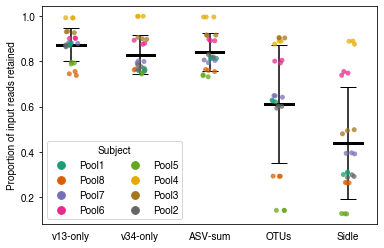

In [59]:
ax = plt.axes()
sn.stripplot(
    x='method',
    y='proportion input',
    hue='subject',
    data=total_counts.sort_values(['method']),
    palette='Dark2',
    jitter=True,
    alpha=0.75,
)
ax.legend_.set_visible(False)
ax.legend(ncol=2, title='Subject')
ax.plot(
    np.vstack([np.arange(0, 5) + i for i in [-0.2, 0.2]]),
    np.vstack([total_counts.groupby('method').mean()['proportion input']] * 2),
    'k-',
    linewidth=3,
    zorder=0,
)
ax.errorbar(
    x=np.arange(0, 5),
    y=total_counts.groupby('method').mean()['proportion input'],
    yerr=total_counts.groupby('method').std()['proportion input'],
    linestyle='',
    capsize=8,
    color='k',
    linewidth=1.5,
)
ax.set_ylabel('Proportion of input reads retained')
ax.set_xticklabels([x._text.split('.')[1] for x in ax.get_xticklabels()])
ax.set_xlabel('')
ax.xaxis.set_tick_params(bottom=False)

## Species level resolution

A second question is which methods provide the best species level resolution. We can't test OTUs, since these inheriet their taxonomy directly from the database. 

For the three ASV-based methods, we'll look for empty strings in the taxonomic labels.

In [60]:
feature_tables_q2 = {
    method: {'table': Artifact.load(f'{method_dir}/{method}/table.qza'),
             'taxa': Artifact.load(f'{method_dir}/{method}/taxonomy.qza'),
             }
    for method in methods
}

In [66]:
feature_table_taxa = {
    method: arts['taxa'].view(pd.Series)[list(arts['table'].view(biom.Table).ids('observation'))]
    for method, arts in feature_tables_q2.items()
}
asv_table_taxa = {
    method: taxa.apply(lambda x: pd.Series(list(x.split(';'))))
    for method, taxa in feature_table_taxa.items()
    if method in { '1.v13-only', '4.merged-asvs-smash', '2.v34-only'}
}

In [73]:
num_undefined = pd.DataFrame({method: taxa.isna().sum(axis=0) 
                              for method, taxa in asv_table_taxa.items()})
num_undefined

,1.v13-only,4.merged-asvs-smash,2.v34-only
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,16,30,8
6,120,212,84


In [77]:
perc_undefined =  pd.DataFrame({method: taxa.isna().mean(axis=0) 
                              for method, taxa in asv_table_taxa.items()})
perc_undefined.round(3)

,1.v13-only,4.merged-asvs-smash,2.v34-only
0,0.000,0.000,0.000
1,0.000,0.000,0.000
2,0.000,0.000,0.000
3,0.000,0.000,0.000
4,0.000,0.000,0.000
5,0.028,0.031,0.024
6,0.207,0.218,0.247


In [81]:
lacto_num_undefined = pd.DataFrame({
    method: taxa.loc[taxa[4].isin(['f__Lactobacillaceae'])].isna().sum(axis=0)[[5, 6]]
    for method, taxa in asv_table_taxa.items()})
lacto_num_undefined

,1.v13-only,4.merged-asvs-smash,2.v34-only
5,0,1,0
6,7,56,25


In [83]:
lacto_perc_undefined = pd.DataFrame({
    method: taxa.loc[taxa[4].isin(['f__Lactobacillaceae'])].isna().mean(axis=0)[[5, 6]]
    for method, taxa in asv_table_taxa.items()})
lacto_perc_undefined.round(3)

,1.v13-only,4.merged-asvs-smash,2.v34-only
5,0.000,0.006,0.00
6,0.067,0.326,0.51


In [90]:
unresolved = feature_table_taxa['5.sidle'].copy().apply(lambda x: '|' in x)
feature_table_taxa['5.sidle'].loc[unresolved]

Feature ID
rRNA_AY485603.1_1-1468_DIR+|rRNA_GU045378.1_2-1475_DIR+    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
Name: Taxon, dtype: object

In [91]:
feature_table_taxa['5.sidle'].loc[unresolved].values

array(['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Streptococcus;s__Streptococcus_infantis|s__Streptococcus_oralis'],
      dtype=object)

In [92]:
unresolved.sum()

1

In [93]:
unresolved.mean()

0.012048192771084338

## Within sample variability